## Kalman Filter for X, Y, Z

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def load_poses(path, sc_factor=1.0):
    poses = []
    with open(path, "r") as f:
        lines = f.readlines()
    for line in lines:
        c2w = np.array(list(map(float, line.split()))).reshape(4, 4)
        c2w[:3, 1] *= -1
        c2w[:3, 2] *= -1
        c2w[:3, 3] *= sc_factor
        c2w = torch.from_numpy(c2w).float()
        poses.append(c2w)
    return poses

def extract_positions(poses):
    positions = []
    for pose in poses:
        position = pose[:3, 3].numpy()
        positions.append(position)  # Now including all x, y, z
    return np.array(positions)

class KalmanFilter:
    def __init__(self, initial_state, initial_P, F, H, Q, R):
        self.state = initial_state
        self.P = initial_P
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
    
    def predict(self):
        self.state = np.dot(self.F, self.state)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
    
    def update(self, measurement):
        y = measurement - np.dot(self.H, self.state)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.state = self.state + np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)

# Load and prepare data
poses = load_poses('./data/Replica/room1/traj.txt', sc_factor=1.0)
positions = extract_positions(poses)

# Add some noise to the measurements
noise_std_dev = 0.001
noisy_positions = positions + np.random.normal(0, noise_std_dev, positions.shape)

# Initialize Kalman Filter
dt = 1.0  # time step
F = np.array([[1, 0, 0, dt, 0, 0],
              [0, 1, 0, 0, dt, 0],
              [0, 0, 1, 0, 0, dt],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])
Q = np.eye(6) * 0.01
R = np.eye(3) * 0.1
initial_state = np.array([positions[0][0], positions[0][1], positions[0][2], 0, 0, 0])
initial_P = np.eye(6)

kf = KalmanFilter(initial_state, initial_P, F, H, Q, R)

# Apply Kalman Filter
filtered_positions = []
for pos in noisy_positions:
    kf.predict()
    kf.update(pos)
    filtered_positions.append(kf.state[:3])

filtered_positions = np.array(filtered_positions)

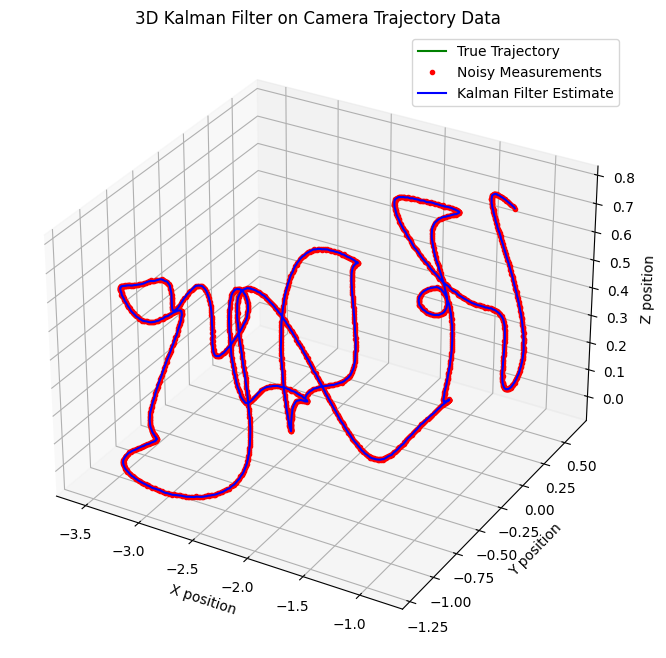

Number of poses processed: 2000
Noise standard deviation: 0.001
Process noise covariance (Q) diagonal: [0.01 0.01 0.01 0.01 0.01 0.01]
Measurement noise covariance (R) diagonal: [0.1 0.1 0.1]


In [5]:
# Plot results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'g-', label='True Trajectory')
ax.plot(noisy_positions[:, 0], noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax.plot(filtered_positions[:, 0], filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax.legend()
ax.set_title('3D Kalman Filter on Camera Trajectory Data')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.show()

# Print some statistics
print(f"Number of poses processed: {len(positions)}")
print(f"Noise standard deviation: {noise_std_dev}")
print(f"Process noise covariance (Q) diagonal: {np.diagonal(Q)}")
print(f"Measurement noise covariance (R) diagonal: {np.diagonal(R)}")

##
## Making sure the 3d plot is valid by ploting 2 - 2d plots
##

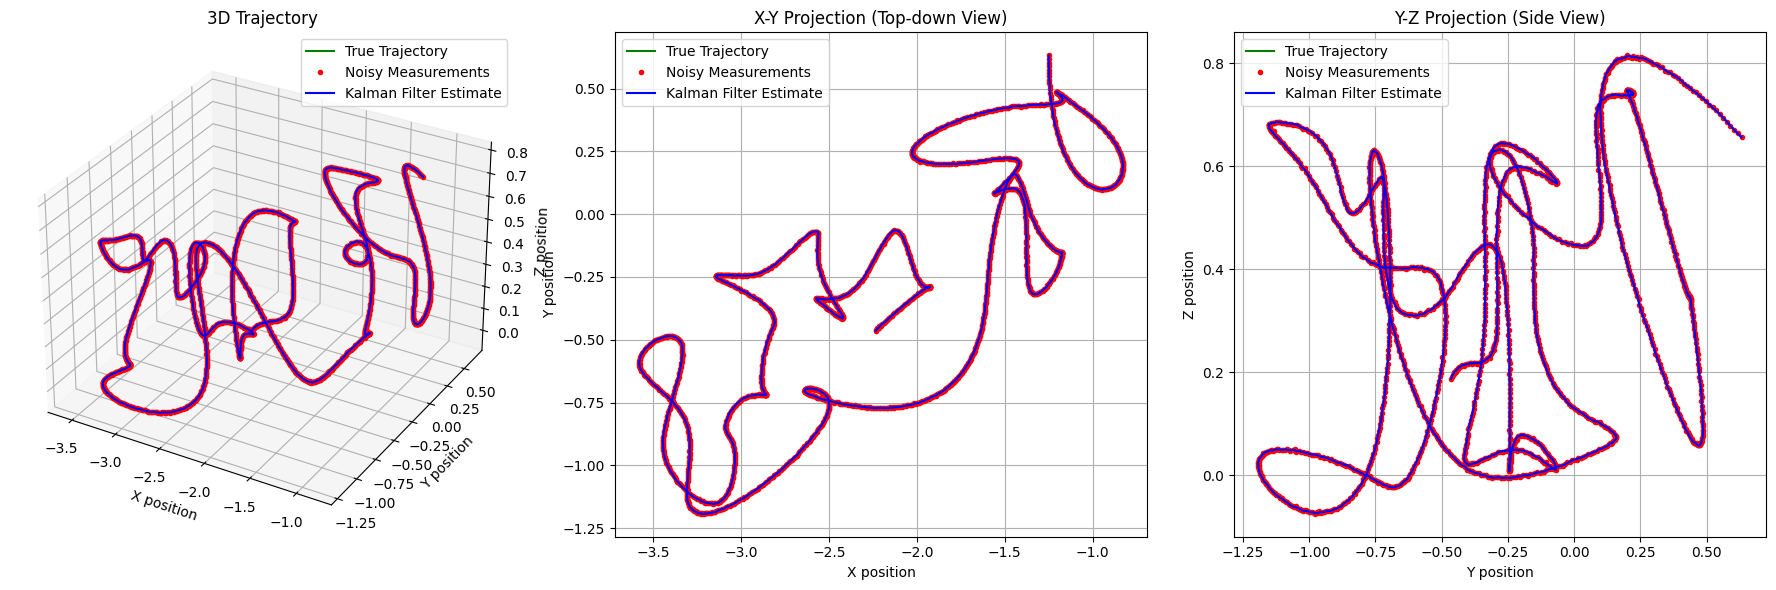

In [72]:
# Plot results
fig = plt.figure(figsize=(18, 6))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'g-', label='True Trajectory')
ax1.plot(noisy_positions[:, 0], noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax1.plot(filtered_positions[:, 0], filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax1.legend()
ax1.set_title('3D Trajectory')
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
ax1.set_zlabel('Z position')

# X-Y projection (top-down view)
ax2 = fig.add_subplot(132)
ax2.plot(positions[:, 0], positions[:, 1], 'g-', label='True Trajectory')
ax2.plot(noisy_positions[:, 0], noisy_positions[:, 1], 'r.', label='Noisy Measurements')
ax2.plot(filtered_positions[:, 0], filtered_positions[:, 1], 'b-', label='Kalman Filter Estimate')
ax2.legend()
ax2.set_title('X-Y Projection (Top-down View)')
ax2.set_xlabel('X position')
ax2.set_ylabel('Y position')
ax2.grid(True)

# Y-Z projection (side view)
ax3 = fig.add_subplot(133)
ax3.plot(positions[:, 1], positions[:, 2], 'g-', label='True Trajectory')
ax3.plot(noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax3.plot(filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax3.legend()
ax3.set_title('Y-Z Projection (Side View)')
ax3.set_xlabel('Y position')
ax3.set_ylabel('Z position')
ax3.grid(True)

plt.tight_layout()
plt.show()